In [401]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12

from scipy.signal import lfilter, butter
from scipy.linalg import eigh

from sklearn.cluster import KMeans

import nibabel as nib
import os

from tqdm.auto import tqdm

folder = '/data/facca/'

TR = 0.72
lfreq = 0.008
hfreq = 0.09

cmap = 'coolwarm'

In [106]:
def bp_filter(data, lfreq=lfreq, hfreq=hfreq, TR=TR):
    b, a = butter(2, np.array([lfreq, hfreq])*2*TR, btype='band')
    return lfilter(b, a, data)

In [107]:
def load_data(subj):
    data = []

    for fname in os.listdir(folder):
        if str(subj) in fname:
            print(fname)
            tmp = nib.load(folder+fname).get_fdata().T
            data.append(tmp)
            
    return data

In [108]:
### Get subjects names
subjs = []

for fname in os.listdir(folder):
    if 'REST1' in fname:
        subjs.append(int(fname.split('.')[0]))
        
print('N subjects:', len(subjs))

N subjects: 40


In [109]:
data = load_data(subjs[1])

352132.REST1.LR.Schaefer.ptseries.nii
352132.REST1.RL.Schaefer.ptseries.nii
352132.REST2.LR.Schaefer.ptseries.nii
352132.REST2.RL.Schaefer.ptseries.nii


In [110]:
filtered = [bp_filter(tmp) for tmp in data]

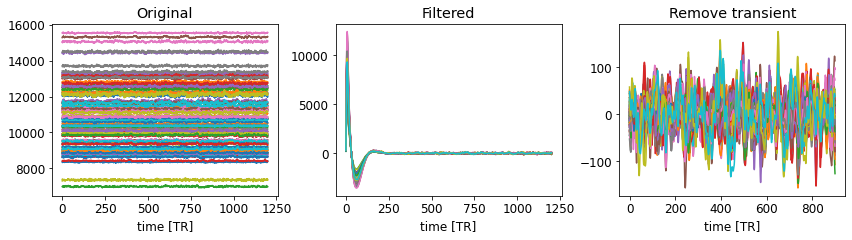

In [191]:
offset = 300

plt.figure(figsize=(12,3.5))

plt.subplot(1,3,1)
plt.plot(data[0].T)
plt.title('Original')
plt.xlabel('time [TR]')

plt.subplot(1,3,2)
plt.plot(filtered[0].T)
plt.title('Filtered')
plt.xlabel('time [TR]')

plt.subplot(1,3,3)
plt.plot(filtered[0][:,offset:].T)
plt.title('Remove transient')
plt.xlabel('time [TR]')

plt.tight_layout()
plt.show()

In [162]:
bold = filtered[0][:,offset:]
N, Tmax = bold.shape
print(N, Tmax)

fc = np.corrcoef(bold)

100 900


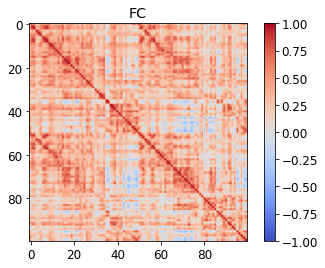

In [194]:
plt.imshow(fc, cmap=cmap, vmin=-1, vmax=1)
plt.colorbar()
plt.title('FC')
plt.show()

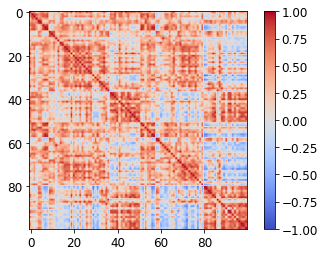

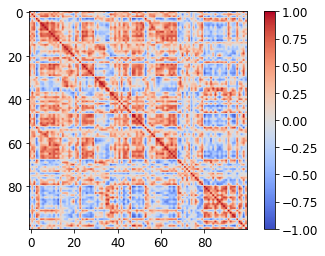

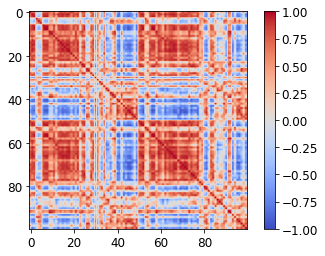

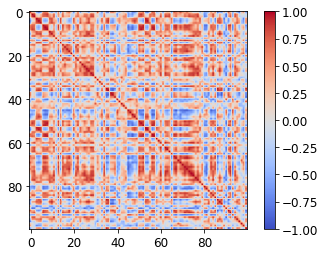

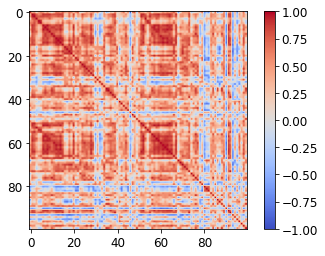

In [197]:
window = 50
shift = 50

for tt in range(5):
    tmp = bold[:,tt*shift:tt*shift+window]
    plt.imshow(np.corrcoef(tmp), cmap=cmap, vmin=-1, vmax=1)
    plt.colorbar()
    plt.show()

In [402]:
def compute_dfc(bold, window=60, shift=2, zscore=True, compute_eig=True):
    N, Tmax = bold.shape
    n_fcd = (Tmax - window) // shift
    
    dfc = np.zeros((n_fcd,n_fcd))
    reduced = np.zeros((n_fcd, N*(N-1)//2))
    idx = np.triu_indices(N,1)

    for i in tqdm(range(n_fcd-1)):
        #if i%10==0:
        #    print(f'{i+1}/{n_fcd-1}')
            
        tmp_X = bold[:,i*shift:i*shift+window]
        tmp_X = np.corrcoef(tmp_X)
        
        if compute_eig:
            # z-score FC(t)
            if zscore:
                tmp = np.arctanh(tmp_X)
                tmp[np.isnan(tmp)] = 0
                tmp[np.isinf(tmp)] = 0
                eigvals, eigvec = eigh(tmp)
            else:
                eigvals, eigvec = eigh(tmp_X)
                                
            # Compute largest eigenvector
            eigvec = eigvec[np.argmax(eigvals)]
            eigvec = eigvec[:,None] * eigvec
            reduced[i] = eigvec[idx]
            
            '''
            plt.imshow(tmp_X, cmap=cmap)
            plt.colorbar()
            plt.show()
            plt.imshow(eigvec, cmap=cmap)
            plt.colorbar()
            plt.show()
            '''
            
        tmp_X = tmp_X[idx]
    
        for j in range(i+1,n_fcd):
            tmp_Y = bold[:,j*shift:j*shift+window]
            tmp_Y = np.corrcoef(tmp_Y)[idx]
        
            dfc[i,j] = np.corrcoef(tmp_X, tmp_Y)[0,1]
        
    dfc += dfc.T + np.eye(n_fcd)
    
    return dfc, reduced

In [403]:
dfc, reduced = compute_dfc(bold)

  0%|          | 0/419 [00:00<?, ?it/s]

/home/barzon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in arctanh


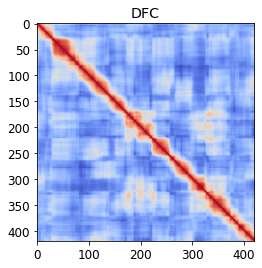

In [404]:
plt.imshow(dfc, cmap=cmap, interpolation='none')
plt.title('DFC')
plt.show()

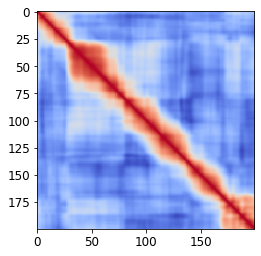

In [387]:
plt.imshow(dfc[:200,:200], cmap=cmap, interpolation='none')
plt.show()

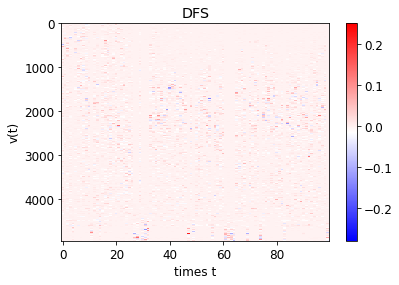

In [388]:
plt.imshow(reduced[:100].T, cmap='bwr', aspect='auto', interpolation='none')
plt.colorbar()
plt.ylabel('v(t)')
plt.xlabel('times t')
plt.title('DFS')
plt.show()

In [419]:
# K-means clustering
fitter = KMeans(n_clusters=4).fit(res_concat)

In [420]:
centroids  = fitter.cluster_centers_

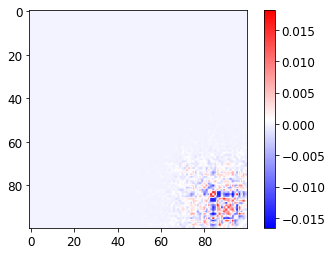

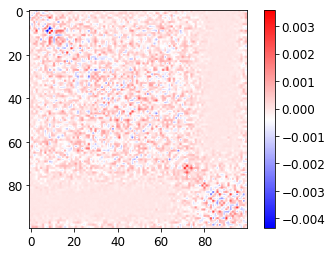

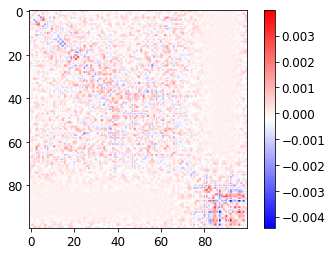

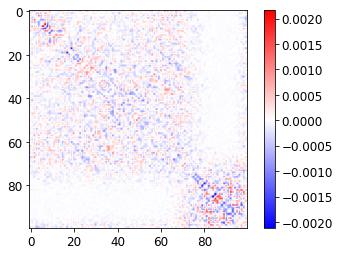

In [421]:
for tmp in centroids:
    # Reconstruct matrix
    mat = np.zeros((N,N))
    idx = np.triu_indices(N,1)
    mat[idx] = tmp
    mat += mat.T
    
    plt.imshow(mat, cmap='bwr')
    plt.colorbar()
    plt.show()

In [412]:
offset = 300

ress = []

for i, subj in enumerate(subjs[:5]):
    print(f'#### {i+1}/{len(subjs)}')
    
    ### Load data
    print('Load data...')
    data = load_data(subj)
    
    ### Band-pass filter
    data = [bp_filter(tmp) for tmp in data]
    
    ### Remove initial transient
    data = [tmp[:,offset:] for tmp in data]
    
    ### Computing DFC
    print('Computing DFC...')
    reduced = [compute_dfc(tmp)[1] for tmp in data]
    reduced = np.vstack(reduced)
    
    ress.append(reduced)

#### 1/40
Load data...
352132.REST1.LR.Schaefer.ptseries.nii
352132.REST1.RL.Schaefer.ptseries.nii
352132.REST2.LR.Schaefer.ptseries.nii
352132.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/419 [00:00<?, ?it/s]

/home/barzon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in arctanh


  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

#### 2/40
Load data...
352132.REST1.LR.Schaefer.ptseries.nii
352132.REST1.RL.Schaefer.ptseries.nii
352132.REST2.LR.Schaefer.ptseries.nii
352132.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

#### 3/40
Load data...
352738.REST1.LR.Schaefer.ptseries.nii
352738.REST1.RL.Schaefer.ptseries.nii
352738.REST2.LR.Schaefer.ptseries.nii
352738.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

#### 4/40
Load data...
352738.REST1.LR.Schaefer.ptseries.nii
352738.REST1.RL.Schaefer.ptseries.nii
352738.REST2.LR.Schaefer.ptseries.nii
352738.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

  0%|          | 0/419 [00:00<?, ?it/s]

#### 5/40
Load data...
353740.REST1.LR.Schaefer.ptseries.nii
353740.REST1.RL.Schaefer.ptseries.nii
353740.REST2.LR.Schaefer.ptseries.nii
353740.REST2.RL.Schaefer.ptseries.nii
Computing DFC...


  0%|          | 0/419 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [414]:
res_concat = np.vstack(ress)

In [415]:
res_concat.shape

(6720, 4950)